# Ce modèle 

In [18]:
from datasets import load_dataset
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torch import nn, optim
import matplotlib.pyplot as plt
from PIL import Image

In [19]:
# Charger le dataset
dataset = load_dataset("aditya11997/dog_heart_xray_data", split="train")
print(f"Nombre total d'exemples : {len(dataset)}")

Nombre total d'exemples : 208


In [20]:
# Aperçu d’un exemple
example = dataset[0]
print("Description :", example["text"])
example["image"].show()

Description : In the dog's chest X-ray and the chest x-ray shows a diminished heart outline.


In [21]:
def texte_vers_label(texte):
    texte = texte.lower()
    mots_clefs_malades = [
        "cardiaque diminué", "silhouette réduite",
        "cardiomégalie", "volume cardiaque réduit", "dilatation"
    ]
    return int(any(mot in texte for mot in mots_clefs_malades))

# Créer la liste des labels
labels = [texte_vers_label(ex["text"]) for ex in dataset]

# Vérifier quelques exemples
for i in range(5):
    print(f"Texte : {dataset[i]['text'][:80]}... ➡️ Label : {labels[i]}")

Texte : In the dog's chest X-ray and the chest x-ray shows a diminished heart outline.... ➡️ Label : 0
Texte : In the dog's chest X-ray and a reduced cardiac silhouette is evident in the ches... ➡️ Label : 0
Texte : In the dog's chest X-ray, a diminutive heart structure is observed, warranting a... ➡️ Label : 0
Texte : A reduced heart size is visible in the canine thoracic X-ray and thoracic x-ray ... ➡️ Label : 0
Texte : The chest X-ray shows a diminished heart outline and thoracic x-ray revealing a ... ➡️ Label : 0


In [22]:
from torch.utils.data import Dataset

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor()
])

# Dataset personnalisé
class DogHeartXrayDataset(Dataset):
    def __init__(self, hf_dataset, labels, transform=None):
        self.hf_dataset = hf_dataset
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        image = self.hf_dataset[idx]["image"]

        # ✅ Ajout important : conversion en RGB si nécessaire
        if image.mode != 'RGB':
            image = image.convert('RGB')

        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Créer l'instance
torch_dataset = DogHeartXrayDataset(dataset, labels, transform)

# Vérification rapide
img, lbl = torch_dataset[0]
print("Taille image :", img.shape, "→ Label :", lbl)

Taille image : torch.Size([3, 224, 224]) → Label : 0


In [23]:
from torch.utils.data import random_split

# Taille du dataset
total_size = len(torch_dataset)
val_size = int(0.2 * total_size)  # 20% validation
train_size = total_size - val_size

# Division aléatoire
train_dataset, val_dataset = random_split(torch_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Vérification d'un batch
images, labels = next(iter(train_loader))
print(f"Batch : {images.shape}, Labels : {labels}")

Batch : torch.Size([16, 3, 224, 224]), Labels : tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [24]:
from torchvision.models import resnet18
from torch import nn, optim

# Charger ResNet18 préentraîné
model = resnet18(pretrained=True)

# Adapter la dernière couche à 2 classes (sain / malade)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# Mettre sur GPU si dispo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Définir la fonction de perte et l’optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

print(f"Modèle prêt sur : {device}")

Modèle prêt sur : cpu


In [25]:
num_epochs = 5
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Époque {epoch+1}/{num_epochs} → "
            f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

Époque 1/5 → Train Loss: 0.2379, Acc: 0.8743 | Val Loss: 0.1238, Acc: 1.0000
Époque 2/5 → Train Loss: 0.0040, Acc: 1.0000 | Val Loss: 0.0089, Acc: 1.0000
Époque 3/5 → Train Loss: 0.0009, Acc: 1.0000 | Val Loss: 0.0011, Acc: 1.0000
Époque 4/5 → Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0005, Acc: 1.0000
Époque 5/5 → Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0004, Acc: 1.0000


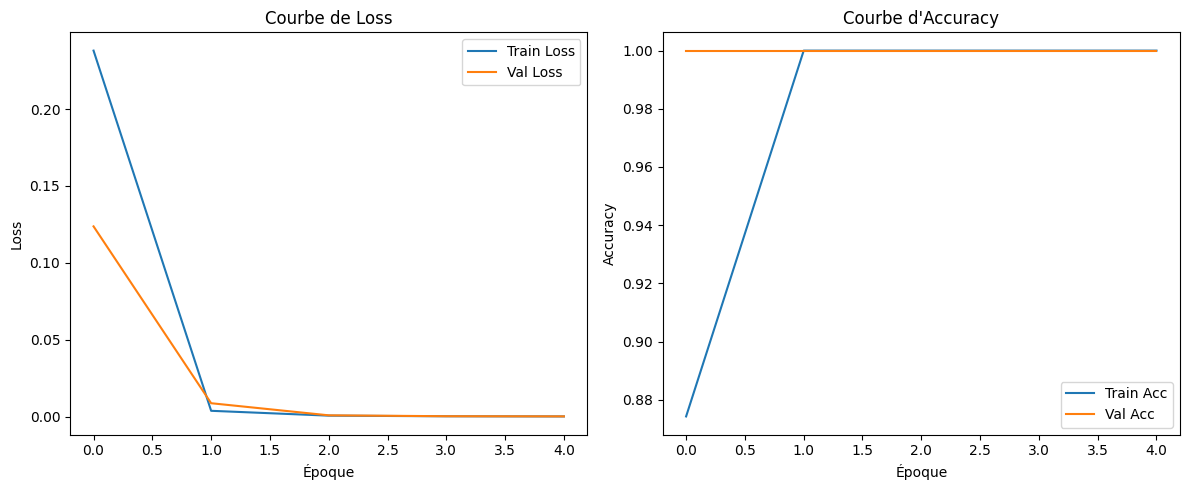

In [26]:
# Courbes de loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Courbe de Loss")
plt.xlabel("Époque")
plt.ylabel("Loss")
plt.legend()

# Courbes d'accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Courbe d'Accuracy")
plt.xlabel("Époque")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()